# Portland Neighborhood Search
Coursera IBM Data Science Capstone Project<br>
<br>
Maribeth Todd <br>
May 2020 <br>

### Introduction
Choosing the right neighborhood to buy a house in can be difficult, with an overwhelming array of features and locations to choose from within an urban area. To narrow it down, we can use Foursquare and other data sources to locate the amenities we care about and find neighborhoods with the right mix of services for our personal preferences. This analysis would be of interest to anyone looking to choose a neighborhood in which to buy a house, as well as real estate professionals trying to help their clients choose the right neighborhood.

When I was looking to buy a house in Portland, Oregon, I was new to the city and didn't know much about the neighborhoods. I looked at data from the Census Bureau, local schools, and other sources to choose a few neighborhoods, and then went to Google maps to figure out if those neighborhoods had the amenities that were important to me (e.g. grocery stores, etc.) This research process was time consuming and somewhat arbitrary, so this project will create a more systematic process for narrowing the search for the right house in the right neighborhood, using Portland as an example.

### Data
The data sources for this project include business location data from Foursquare, Census data, and the Mapquest geocoding API. 

I use Census data to define the neighborhoods in the Portland region and obtain some basic information like population density and average housing values. The neighborhoods are based on census tracts in order to take advantage of the wide variety of data available in the Census American Community Survey. Since the Foursqaure API takes lat/long points as input, neighborhoods are defined using the mean center of population for every census tract in the Portland region. This concept is more representative of the location of population within each tract than a geographic center would be. The Census Bureau provides latitude and longitude data for the mean center of population for various geographic levels <a href="https://www.census.gov/geographies/reference-files/2010/geo/2010-centers-population.html" target="_blank">here</a>.

Other attributes are obtained from the Census American Community Survey API and TIGER/Line files. The Census ACS includes data on a wide variety of aspects that may be of interest to a potential homebuyer, including average house values, and demographic information like age and the number of households with kids. The TIGER/line shapefile provides the area of the tracts for calculating population densities.

Using the Foursqaure API, I find the locations of the types of businesses that I would like to have within walking distance in my neighborhood. My preferences for a neighborhood include some essential services like grocery stores, a library, a hardware store, and some restaurants. Someone else might prefer different amenities, like bars and bike shops, in their ideal neighborhood so this approach could be customized for different preferences. 

The goal is to use the Census and Foursquare data to cluster neighborhoods into similar groups. This will help narrow the search for the right location and provide a manageable list of neighborhoods for further exploration. The Mapquest API is used to assign each census tract center to a zip code, to facilitate linking the results of the cluster analysis out to real estate listings.

### Methodology

The first step is importing the necessary Census data, including the neighborhood points and ACS data to link to those points. The Portland region includes three counties, and only tracts within the urban portions of those counties are included in the analysis.


In [1]:
import census
import numpy as np
import pandas as pd
import requests

Import the population center points to use as the neighborhoods:

In [2]:
#import the center of population for each tact in the 3-county Portland metro region
tract_centers = pd.read_csv('https://www2.census.gov/geo/docs/reference/cenpop2010/tract/CenPop2010_Mean_TR41.txt')
tract_centers = tract_centers[tract_centers['COUNTYFP'].isin([5, 51, 67])]
#create 11 digit tract code for linking to ACS data
tract_centers['GEOID'] = tract_centers['STATEFP'].astype(str) + tract_centers['COUNTYFP'].astype(str).str.zfill(3) + tract_centers['TRACTCE'].astype(str).str.zfill(6)
tract_centers.reset_index(inplace=True, drop=True)
tract_centers = tract_centers.loc[:,['GEOID', 'LATITUDE', 'LONGITUDE']]
tract_centers.loc[:,'GEOID'] = tract_centers.loc[:, 'GEOID'].astype(str)
print(len(tract_centers))
tract_centers.head()

355


,GEOID,LATITUDE,LONGITUDE
0,41005020100,45.426568,-122.676912
1,41005020200,45.414983,-122.687878
2,41005020302,45.410525,-122.733985
3,41005020303,45.427063,-122.715095
4,41005020304,45.426422,-122.732191


Import the tract shapefile that includes the land area of tracts and a flag identifying which tracts are in the urban area:

In [3]:
tract_table = pd.read_csv("D:/IBM_Coursera/Capstone/census/tracts_3county.csv")
tract_area = tract_table.loc[:, ['GEOID', 'ALAND', 'UGB']]
tract_area.loc[:, 'GEOID'] = tract_area.loc[:, 'GEOID'].astype(str)
tract_area.head()

,GEOID,ALAND,UGB
0,41051006602,2534568.0,1
1,41051010200,27658246.0,1
2,41051002401,842230.0,1
3,41051002402,878222.0,1
4,41051002501,1338433.0,1


Now download some ACS data from the Census API. Set up the Census API key:

In [4]:
from census import Census
c = Census("removed for posting to Github")

Total population from table B01003:

In [5]:
C_pop = c.acs5.state_county_tract('B01003_001E', '41', '005', Census.ALL)
M_pop = c.acs5.state_county_tract('B01003_001E', '41', '051', Census.ALL)
W_pop = c.acs5.state_county_tract('B01003_001E', '41', '067', Census.ALL)
total_pop_list = C_pop + M_pop + W_pop
total_pop = pd.DataFrame(total_pop_list, columns = ['B01003_001E', 'state', 'county', 'tract'])
total_pop['GEOID'] = total_pop['state'].astype(str) + total_pop['county'].astype(str) + total_pop['tract'].astype(str)
total_pop.head()

,B01003_001E,state,county,tract,GEOID
0,3640.0,41,005,020403,41005020403
1,3750.0,41,005,020404,41005020404
2,6563.0,41,005,020504,41005020504
3,2562.0,41,005,020505,41005020505
4,6476.0,41,005,022105,41005022105


Median house value from table B25107:

In [6]:
C_value = c.acs5.state_county_tract('B25107_001E', '41', '005', Census.ALL)
M_value = c.acs5.state_county_tract('B25107_001E', '41', '051', Census.ALL)
W_value = c.acs5.state_county_tract('B25107_001E', '41', '067', Census.ALL)
value_list = C_value + M_value + W_value
value = pd.DataFrame(value_list, columns = ['B25107_001E', 'state', 'county', 'tract'])
value['GEOID'] = value['state'].astype(str) + value['county'].astype(str) + value['tract'].astype(str)
value.head()

,B25107_001E,state,county,tract,GEOID
0,733400.0,41,005,020403,41005020403
1,632900.0,41,005,020404,41005020404
2,485000.0,41,005,020504,41005020504
3,443100.0,41,005,020505,41005020505
4,363000.0,41,005,022105,41005022105


Combine all of the census data sets into a single dataframe.

In [7]:
tract_acs = pd.merge(total_pop[['GEOID', 'B01003_001E']], value[['GEOID', 'B25107_001E']])
tract_acs.rename(columns = {'B01003_001E':'pop'}, inplace = True)
tract_acs.rename(columns = {'B25107_001E':'value'}, inplace = True)
tract_acs.loc[:,'GEOID'] = tract_acs.loc[:, 'GEOID'].astype(str)
tract_acs.head()

,GEOID,pop,value
0,41005020403,3640.0,733400.0
1,41005020404,3750.0,632900.0
2,41005020504,6563.0,485000.0
3,41005020505,2562.0,443100.0
4,41005022105,6476.0,363000.0


In [8]:
tract_data = pd.merge(tract_area, tract_acs, on='GEOID')
tract_data.loc[:, 'density'] = tract_data['pop']/(tract_data['ALAND']/1000000) #people per sq km
tract_data = tract_data[tract_data['pop']>0]
tract_data = tract_data.join(tract_centers.set_index('GEOID'), on='GEOID')
tract_data = tract_data[tract_data['UGB']==1]
tract_data.head()

,GEOID,ALAND,UGB,pop,value,density,LATITUDE,LONGITUDE
0,41051006602,2534568.0,1,5782.0,413300.0,2281.256609,45.471270,-122.705744
1,41051010200,27658246.0,1,6364.0,232300.0,230.094128,45.546017,-122.450458
2,41051002401,842230.0,1,2761.0,694000.0,3278.201916,45.543274,-122.652470
3,41051002402,878222.0,1,3307.0,427100.0,3765.562694,45.535566,-122.651084
4,41051002501,1338433.0,1,4710.0,702100.0,3519.040550,45.543513,-122.638846


Now use the lat/long data from the Census tract points to collect information from Foursquare on the businesses located in each neighborhood. The map below shows the radius of each neighborhood, set to 800 meters or about a half mile, that will be sent to the Foursquare API. The neighborhoods overlap, which means many businesses could be counted multiple times, but that's ok. The point is to find the businesses that are within a reasonable walking distance of the neighborhood center.

In [63]:
import folium
pdx_center = [45.504091, -122.667556]

map_tracts = folium.Map(location=pdx_center, zoom_start=10.5)
for lat, lon, name in zip(tract_data['LATITUDE'],tract_data['LONGITUDE'], tract_data['GEOID']):
    label = folium.Popup('Tract: {}'.format(str(name)))
    folium.Circle([lat, lon], 
                  radius=800, 
                  color='blue', 
                  fill=False, 
                  popup=label).add_to(map_tracts)
#    folium.Marker([lat, lon]).add_to(map_tracts)
map_tracts.save('map_tracts.html')
map_tracts

Set up Foursquare API credentials and define a function to gather data for each of the neighborhoods.

In [10]:
CLIENT_ID = 'removed for posting to Github'
CLIENT_SECRET = 'removed for posting to Github'
VERSION = '20180605'
LIMIT = 30

In [11]:
def getNearbyCategory(category, names, latitudes, longitudes, radius):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            category, 
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
    # make the GET request
        results = requests.get(url).json()['response']['venues']
        
    # return only relevant information for each nearby venue
        if len(results)>0:
            for v in results:
                venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name'])])
        else:
            venues_list.append([(
                name, 
                lat, 
                lng, 
                "", 
                "", 
                "",  
                "")])
    
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

This function searches by category, so we also need to define the codes for the venue categories of interest. I am using venues of interest to me in this analysis, but these could be changed if, for example, a real estate agent was assisting a client with a neighborhood search.

In [12]:
libraryId = '4bf58dd8d48988d12f941735'
groceryId = '4bf58dd8d48988d118951735'
foodId = '4d4b7105d754a06374d81259'
hardwareId = '4bf58dd8d48988d112951735'

In [13]:
data = tract_data
names=data['GEOID']
lat=data['LATITUDE']
lng=data['LONGITUDE']
radius=800

Now make the Foursquare API call for each of the four categories defined above (libraries, grocery stores, restaurants and other food purveyors, and hardware stores). The search returns some venues that don't really fit the categories, so an additional filtering step is applied to ensure the venues are relevant. Each venue type is summarized at the tract level, so the result is the count of each venue type in each neighborhood.

In [14]:
tract_library = getNearbyCategory(libraryId, names, lat, lng, radius)

In [15]:
tract_library['library'] = 0
tract_library.loc[tract_library['Venue Category']=='Library','library'] = 1

library_grouped = tract_library.groupby('Neighborhood', as_index=False).sum()
library_grouped = library_grouped.loc[:,['Neighborhood', 'library']]
library_grouped.head()

,Neighborhood,library
0,41005020100,1
1,41005020200,0
2,41005020302,0
3,41005020303,0
4,41005020304,0


In [16]:
tract_grocery = getNearbyCategory(groceryId, names, lat, lng, radius)

In [17]:
tract_grocery['grocery'] = 0
tract_grocery.loc[tract_grocery['Venue Category'].isin(['Grocery Store', 'Supermarket']),'grocery'] = 1

grocery_grouped = tract_grocery.groupby('Neighborhood', as_index=False).sum()
grocery_grouped = grocery_grouped.loc[:,['Neighborhood', 'grocery']]
grocery_grouped.head()

,Neighborhood,grocery
0,41005020100,1
1,41005020200,0
2,41005020302,1
3,41005020303,0
4,41005020304,0


In [18]:
tract_hardware = getNearbyCategory(hardwareId, names, lat, lng, radius)

In [19]:
tract_hardware['hardware'] = 0
tract_hardware.loc[tract_hardware['Venue Category'] == 'Hardware Store','hardware'] = 1

hardware_grouped = tract_hardware.groupby('Neighborhood', as_index=False).sum()
hardware_grouped = hardware_grouped.loc[:,['Neighborhood', 'hardware']]
hardware_grouped.head()

,Neighborhood,hardware
0,41005020100,0
1,41005020200,0
2,41005020302,2
3,41005020303,0
4,41005020304,0


In [20]:
tract_food = getNearbyCategory(foodId, names, lat, lng, radius)

In [21]:
tract_food['food'] = 1
tract_food.loc[tract_food['Venue Category'].isna(),'food'] = 0

food_grouped = tract_food.groupby('Neighborhood', as_index=False).sum()
food_grouped = food_grouped.loc[:,['Neighborhood', 'food']]
food_grouped.head()

,Neighborhood,food
0,41005020100,10
1,41005020200,1
2,41005020302,12
3,41005020303,1
4,41005020304,20


Collate and format the data for clustering analysis. Drop records with no house value data (where value < 0) because these are nonresidential areas.

In [48]:
from functools import reduce
df = [food_grouped, grocery_grouped, library_grouped, hardware_grouped]
tract_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Neighborhood'],
                                            how='outer'), df)
tract_merged = pd.merge(tract_merged, tract_data.loc[:,['GEOID', 'value', 'density']], left_on = 'Neighborhood', right_on = 'GEOID')
tract_merged.drop('GEOID', axis=1, inplace=True)
tract_merged = tract_merged[tract_merged['value']>0]
tract_merged.head()

,Neighborhood,food,grocery,library,hardware,value,density
0,41005020100,10,1,1,0,753900.0,907.025096
1,41005020200,1,0,0,0,744100.0,1097.855690
2,41005020302,12,1,0,2,471300.0,1215.674685
3,41005020303,1,0,0,0,519000.0,2451.889806
4,41005020304,20,0,0,0,585200.0,2275.745371


Some summary statistics on the dataset indicate that most neighborhoods do not have a library or hardware store. A little more than a third of neighborhoods have no grocery store, and all neighborhoods have at least one restaurant, coffee shop, or other prepared food venue. This suggests that libraries and hardware stores may be stronger limiting factors than grocery stores and restaurants in which neighborhoods are most suitable.

In [23]:
tract_merged['library'].value_counts()

0    206
1     78
2     12
4      6
3      6
7      1
6      1
5      1
Name: library, dtype: int64

In [24]:
tract_merged['hardware'].value_counts()

0     153
1      66
2      45
4      14
3      14
5       5
6       4
7       3
10      2
25      1
17      1
12      1
9       1
8       1
Name: hardware, dtype: int64

In [25]:
tract_merged['grocery'].value_counts()

0     115
1      71
2      58
3      32
4      12
5       9
7       5
9       3
6       3
8       2
10      1
Name: grocery, dtype: int64

In [26]:
tract_merged['food'].value_counts()

30    41
1     32
26    27
27    18
25    17
28    13
29    13
2     13
4     10
11    10
7      9
10     9
3      8
15     8
21     8
23     8
8      7
6      7
5      7
12     6
9      6
24     6
20     5
22     5
16     4
19     4
17     3
14     3
18     2
13     2
Name: food, dtype: int64

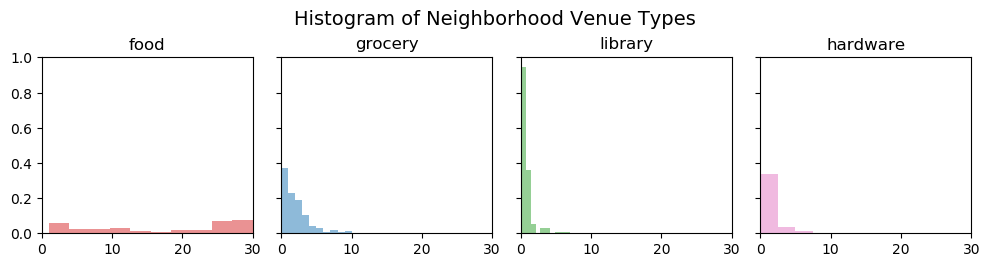

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,2.5), dpi=100, sharex=True, sharey=True)
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:pink', 'tab:olive']

for i, (ax, col) in enumerate(zip(axes.flatten(), ['food', 'grocery', 'library', 'hardware'])):
    x = tract_merged.loc[:, col]
    ax.hist(x, alpha=0.5, bins=10, density=True, stacked=True, label=col, color=colors[i])
    ax.set_title(col)

plt.suptitle('Histogram of Neighborhood Venue Types', y=1.05, size=14)
ax.set_xlim(0, 30); ax.set_ylim(0, 1);
plt.tight_layout();

Prepare the data by choosing the variables to include and scaling the data, then cluster the neighborhoods using the k-means algorithm. This clustering includes the four venue types and population density. Prices will be used for filtering the neighborhoods after the clustering step.

In [28]:
X = tract_merged.values[:,[1,2,3,4,6]]
X[0:5,:]

array([[10, 1, 1, 0, 907.0250960447338],
       [1, 0, 0, 0, 1097.8556903958572],
       [12, 1, 0, 2, 1215.6746849916228],
       [1, 0, 0, 0, 2451.889806040545],
       [20, 0, 0, 0, 2275.745371342706]], dtype=object)

In [29]:
from sklearn.preprocessing import StandardScaler
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[-0.67420892, -0.29437814,  0.48649706, -0.54546744, -0.94175475],
       [-1.51704534, -0.82976761, -0.52894311, -0.54546744, -0.81585306],
       [-0.48691193, -0.29437814, -0.52894311,  0.27207653, -0.73812124],
       ...,
       [ 0.16862751,  0.24101134, -0.52894311,  0.68084851, -1.22398037],
       [ 0.73051846,  0.24101134, -0.52894311,  0.27207653, -1.01986925],
       [-1.51704534, -0.82976761, -0.52894311, -0.54546744, -0.03099415]])

To check for the best number of clusters to use, we need to evaluate the output of the clustering algorithm using different values for k. There are several metrics for k-means including the silhouette coefficient, Davies-Bouldin index and Calinski-Harabsz index. Higher values of the silhouette and Calinski-Harabasz scores indicate better defined clusters, while a lower value of the Davies-Boulding score indicates a model with better separation between the clusters.  (https://scikit-learn.org/stable/modules/clustering.html)

These scores suggest that a model with 8 or 9 clusters presents the best fit, as 8 clusters produces the best silhouette score and 9 clusters produces the best Davies-Bouldin score. The Calinski-Harabasz score continues to improve as the number of clusters increases but at the expense of the other two measures. So this analysis will use 8 clusters.

In [46]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

range_n_clusters = [6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters)
    print("The average silhouette_score is:", silhouette_avg)
    print("The Davies-Bouldin score is: ", davies_bouldin_score(X, clusterer.labels_))
    print("The Calinski-Harabasz score is: ", calinski_harabasz_score(X, clusterer.labels_))



For n_clusters = 6
The average silhouette_score is: 0.5337721658069939
The Davies-Bouldin score is:  0.5223898676524088
The Calinski-Harabasz score is:  868.1423562997466
For n_clusters = 7
The average silhouette_score is: 0.5360241052399844
The Davies-Bouldin score is:  0.510594169258811
The Calinski-Harabasz score is:  1054.2254671732148
For n_clusters = 8
The average silhouette_score is: 0.5611945644355721
The Davies-Bouldin score is:  0.48962958989436406
The Calinski-Harabasz score is:  1213.3881339874192
For n_clusters = 9
The average silhouette_score is: 0.5573757996383902
The Davies-Bouldin score is:  0.39829435647638906
The Calinski-Harabasz score is:  1363.074359289039
For n_clusters = 10
The average silhouette_score is: 0.5477414339151778
The Davies-Bouldin score is:  0.4119750327600145
The Calinski-Harabasz score is:  1622.0993627484888


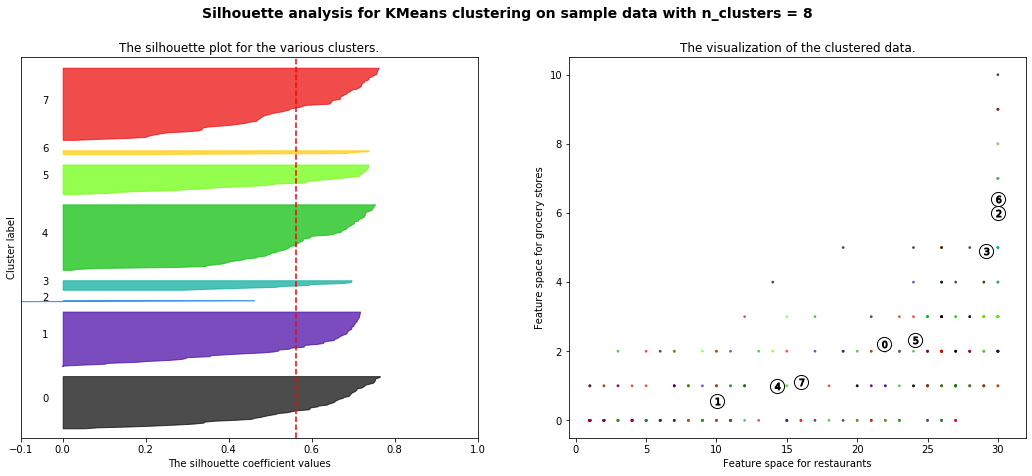

In [42]:

range_n_clusters = [8]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
 #   print("For n_clusters =", n_clusters)
 #   print("The average silhouette_score is:", silhouette_avg)
 #   print("The Davies-Bouldin score is: ", davies_bouldin_score(X, clusterer.labels_))
 #   print("The Calinski-Harabasz score is: ", calinski_harabasz_score(X, clusterer.labels_))

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
        # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for restaurants")
    ax2.set_ylabel("Feature space for grocery stores")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [49]:
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans

kclusters = 8

k_means = KMeans(init = "k-means++", n_clusters = kclusters, n_init = 12)
k_means.fit(X)

tract_merged.insert(0, 'cluster', k_means.labels_)
tract_merged

,cluster,Neighborhood,food,grocery,library,hardware,value,density
0,3,41005020100,10,1,1,0,753900.0,907.025096
1,5,41005020200,1,0,0,0,744100.0,1097.855690
2,5,41005020302,12,1,0,2,471300.0,1215.674685
3,1,41005020303,1,0,0,0,519000.0,2451.889806
4,1,41005020304,20,0,0,0,585200.0,2275.745371
...,...,...,...,...,...,...,...,...
308,3,41067032902,15,0,1,1,235300.0,503.364723
309,3,41067033101,22,1,1,1,303300.0,462.501564
310,3,41067033102,19,2,0,3,254500.0,479.252566
311,3,41067033200,25,2,0,2,232300.0,788.626070


In [50]:
#convert to pd dataframe
tract_merged = pd.merge(tract_merged, tract_centers.set_index('GEOID'), left_on='Neighborhood', right_on='GEOID')
tract_merged.head()

,cluster,Neighborhood,food,grocery,library,hardware,value,density,LATITUDE,LONGITUDE
0,3,41005020100,10,1,1,0,753900.0,907.025096,45.426568,-122.676912
1,5,41005020200,1,0,0,0,744100.0,1097.855690,45.414983,-122.687878
2,5,41005020302,12,1,0,2,471300.0,1215.674685,45.410525,-122.733985
3,1,41005020303,1,0,0,0,519000.0,2451.889806,45.427063,-122.715095
4,1,41005020304,20,0,0,0,585200.0,2275.745371,45.426422,-122.732191


### Results

Some summary statistics on the resulting clusters are shown below. Most neighborhoods fall within clusters 1, 2, 3, 5, and 7. The smaller clusters represent neighborhoods with more rare features such as the very high densities of population and services in the central city in clusters 0 and 4.

In [51]:
tract_merged.groupby('cluster').count()

,Neighborhood,food,grocery,library,hardware,value,density,LATITUDE,LONGITUDE
cluster,,,,,,,,,
0,5,5,5,5,5,5,5,5,5
1,78,78,78,78,78,78,78,78,78
2,56,56,56,56,56,56,56,56,56
3,54,54,54,54,54,54,54,54,54
4,2,2,2,2,2,2,2,2,2
5,72,72,72,72,72,72,72,72,72
6,15,15,15,15,15,15,15,15,15
7,29,29,29,29,29,29,29,29,29


In [52]:
avg = tract_merged.groupby('cluster').mean()
avg.round(1)

,food,grocery,library,hardware,value,density,LATITUDE,LONGITUDE
cluster,,,,,,,,
0,30.0,6.4,3.4,5.4,562500.0,7434.9,45.5,-122.7
1,15.9,1.1,0.4,1.0,344867.9,2237.6,45.5,-122.7
2,21.8,2.2,0.6,1.4,344246.4,2996.1,45.5,-122.6
3,10.4,0.6,0.3,0.7,397498.1,627.9,45.5,-122.7
4,30.0,6.0,2.5,4.0,353250.0,11851.6,45.5,-122.7
5,13.9,1.0,0.2,1.4,414320.8,1508.0,45.5,-122.7
6,29.1,4.5,1.2,2.2,397586.7,4763.3,45.5,-122.7
7,23.6,2.2,0.9,1.7,412282.8,3755.1,45.5,-122.6


From these summary statistics (and the map below) cluster 2 looks promising. It has a moderate population density, low to moderate price level, and most neighborhoods in this cluster have access to at least one of each of the venue types.

In [64]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=pdx_center, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tract_merged['LATITUDE'], tract_merged['LONGITUDE'], tract_merged['Neighborhood'], tract_merged['cluster']):
    label = folium.Popup('Tract: {} <br> Cluster: {}'.format(poi, cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.save("map_clusters.html")
map_clusters

Next, map just the neighborhoods in cluster 2 But first, attach zip codes to each of the neighborhoods so that the points on the map can provide a link to homes for sale in that zip code on Zillow.

In [54]:
#Mapquest credentials
MapquestKEY = 'removed for posting to Github'
MapquestSECRET = 'removed for posting to Github'

In [55]:
def getZIP(name, latitudes, longitudes):
    
    zip_list=[]
    for name, lat, lng in zip(name, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'http://www.mapquestapi.com/geocoding/v1/reverse?key={}&location={},{}&includeRoadMetadata=false&includeNearestIntersection=false'.format(
            MapquestKEY,
            lat,
            lng)
            
    # make the GET request
        zipcode = requests.get(url).json()['results'][0]['locations'][0]['postalCode']
        
    # return only relevant information for each nearby venue
        zip_list.append([(
                    name,
                    zipcode)])
            
        zipcodes = pd.DataFrame([item for zip_list in zip_list for item in zip_list])
        zipcodes.columns = ['Neighborhood', 
                                 'ZIP']
    
    return(zipcodes)

In [56]:
lat=tract_merged['LATITUDE']
lng=tract_merged['LONGITUDE']
name=tract_merged['Neighborhood']
zipcodes = getZIP(name, lat, lng)
zipcodes.head()

,Neighborhood,ZIP
0,41005020100,97034
1,41005020200,97034
2,41005020302,97035
3,41005020303,97035-1911
4,41005020304,97035-2309


In [57]:
tract_zip = pd.merge(tract_merged, zipcodes.set_index('Neighborhood'), on='Neighborhood')
tract_zip.head()

,cluster,Neighborhood,food,grocery,library,hardware,value,density,LATITUDE,LONGITUDE,ZIP
0,3,41005020100,10,1,1,0,753900.0,907.025096,45.426568,-122.676912,97034
1,5,41005020200,1,0,0,0,744100.0,1097.855690,45.414983,-122.687878,97034
2,5,41005020302,12,1,0,2,471300.0,1215.674685,45.410525,-122.733985,97035
3,1,41005020303,1,0,0,0,519000.0,2451.889806,45.427063,-122.715095,97035-1911
4,1,41005020304,20,0,0,0,585200.0,2275.745371,45.426422,-122.732191,97035-2309


To narrow the list down further, look at neighborhoods with a median house value of less than $400,000 and where there is access within a half mile of at least one library. This results in 12 neighborhoods for further exploration.

In [59]:
cluster_subset = tract_zip[tract_zip['cluster']==2]
cluster_subset = cluster_subset[cluster_subset['value'] < 400000]
cluster_subset = cluster_subset[cluster_subset['library'] > 0]
print(len(cluster_subset))
cluster_subset.head()

12


,cluster,Neighborhood,food,grocery,library,hardware,value,density,LATITUDE,LONGITUDE,ZIP
34,2,41005022201,29,3,1,5,153400.0,2823.684148,45.443912,-122.573506,97086-7419
55,2,41051000401,26,3,1,3,378400.0,2862.932324,45.484077,-122.614390,97206-5712
56,2,41051000402,26,1,1,3,329800.0,3006.768646,45.483364,-122.604122,97206
61,2,41051000701,27,2,1,0,376100.0,3334.126672,45.501485,-122.589425,97206-1849
96,2,41051002901,26,2,1,1,355300.0,2900.707405,45.551517,-122.592296,97213-5134


In [65]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

data = cluster_subset

# create map
map_clusters = folium.Map(location=pdx_center, zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, name, cluster, zipcode, food, grocery, hardware, library in zip(data['LATITUDE'],
                                                                             data['LONGITUDE'],
                                                                             data['Neighborhood'],
                                                                             data['cluster'],
                                                                             data['ZIP'],
                                                                             data['food'],
                                                                             data['grocery'],
                                                                             data['hardware'],
                                                                             data['library']):
    label = folium.Popup('Tract: {} <br> Cluster: {} <br> Food: {} <br> Grocery: {} <br> Library: {} <br> Hardware: {} <br> <a href="https://www.zillow.com/homes/{}_rb/" target="_blank">See homes for sale in this zip code on Zillow</a>'.format(name, cluster, food, grocery, library, hardware, zipcode))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_clusters)

map_clusters.save("map_cluster_subset.html")
       
map_clusters

In [61]:
cluster_subset

,cluster,Neighborhood,food,grocery,library,hardware,value,density,LATITUDE,LONGITUDE,ZIP
34,2,41005022201,29,3,1,5,153400.0,2823.684148,45.443912,-122.573506,97086-7419
55,2,41051000401,26,3,1,3,378400.0,2862.932324,45.484077,-122.614390,97206-5712
56,2,41051000402,26,1,1,3,329800.0,3006.768646,45.483364,-122.604122,97206
61,2,41051000701,27,2,1,0,376100.0,3334.126672,45.501485,-122.589425,97206-1849
96,2,41051002901,26,2,1,1,355300.0,2900.707405,45.551517,-122.592296,97213-5134
114,2,41051003802,26,4,1,3,380900.0,3231.880190,45.573388,-122.683536,97217-5415
116,2,41051003901,14,4,1,0,309500.0,3087.668618,45.584355,-122.703428,97217-7345
121,2,41051004102,29,4,1,2,312800.0,2799.260054,45.589105,-122.742399,97203-2411
174,2,41051008600,30,2,1,0,210100.0,3271.945405,45.469250,-122.584592,97206-7814
182,2,41051009201,20,1,2,0,222100.0,3184.997656,45.512687,-122.529614,97233-1719


Now that we have a reasonable number of neighborhoods to explore, we can look at some real estate listings. Click the points on the map to get a link to homes currently for sale in each neighborhood's zip code. From here, choosing the best neighborhood depends on the type of houses available, the commute to work, and other variables that haven't been included so far.

### Discussion

The cluster analysis results are a jumping off point for further exploration of the neighborhoods that meet the criteria laid out above. The direct links to real estate listings make it easy to see the types of houses that are on the market in these neighborhoods and determine if any of them might be a good fit. If none of these neighborhoods seem quite right, we may need to explore a different cluster (cluster 7 seems to be most similar to cluster 2) or we may need to adjust our filtering criteria (price and library access) or redo the cluster analysis using different variables or parameters. Requiring easy library access eliminates about two thirds of the neighborhoods in the Portland region from consideration, so we may decide that library access can be omitted from the analysis or replaced with another venue type.


### Conclusion

Choosing the right neighborhood to live in is a very subjective process and everyone will have their own set of preferences and priorities. In this analysis I have focused on easy walking access to grocery stores, hardware stores, libraries, and restaurants within a half mile. The inclusion of population density in the cluster analysis is a good proxy for the type of built environment and walkability in a neighborhood. The Foursquare data indicate that restaurants and other food venues like coffee shops are readily available in most neighborhoods in the Portland region, and grocery stores are fairly well distributed as well. Hardware stores are less common, and easy access to a library is a much more limiting factor in choosing a neighborhood. 

The ultimate decision of which neighborhood to purchase a house in must include additional factors such as budget, the size and type of houses that are on the market in various neighborhoods, and commutes to work or school, but this is a good way to start narrowing the search. In addition to confirming that the neighborhood I chose to live in still meets all of my needs, this analysis has highlighted some other neighborhoods that I should consider if we decide to move in the future. This type of systematic neighborhood evaluation could be useful for other individuals looking for a new house or real estate professionals assisting clients with their search for a place to live, and can easily be customized to different priorities.